In [1]:
# must use python2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import sys
sys.path.append("/home/anderson/res/eeg/cebl/cebl")
sys.path.append("/home/anderson/res/eeg/cebl/cebl/eeg")
import cebl
import qdalda as ql
import pandas  # to print table of results

Read two data files, one recorded using three tri-ring electrodes at C4, C3, and Pz, and the second recorded using just the outer ring at C4, C3 and Pz.

In [2]:
# for python3
# tri = pickle.load(open('p300spellertri.pkl','rb'), encoding='latin1')
# reg = pickle.load(open('p300spellerouter.pkl','rb'), encoding='latin1')

trifile = pickle.load(open('p300spellertri.pkl'))
regfile = pickle.load(open('p300spellerouter.pkl'))

Each has about 36,000 time samples, or about 140 seconds work of samples, at 256 Hz.  Each sample consists of four values, the three channels plus a marker channel.  The marker channel has positive values for segments when the row or column containing the target letter is flashed.  Other segments have negative values.

In [3]:
36000/256.0

140.625

In [4]:
trifile.shape, regfile.shape

((35961, 4), (36066, 4))

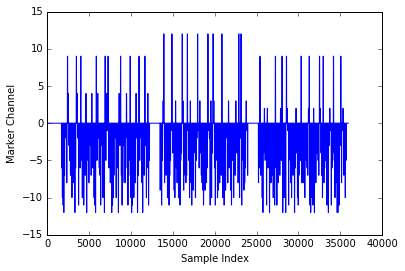

In [5]:
plt.plot(trifile[:,-1])
plt.xlabel('Sample Index')
plt.ylabel('Marker Channel');

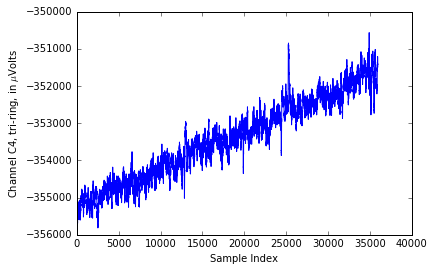

In [6]:
plt.plot(trifile[:,0])
plt.xlabel('Sample Index')
plt.ylabel('Channel C4, tri-ring, in $\mu$Volts');

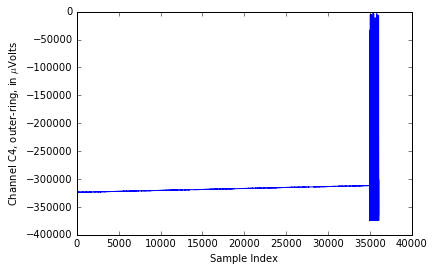

In [7]:
plt.plot(regfile[:,0]);
plt.xlabel('Sample Index')
plt.ylabel('Channel C4, outer-ring, in $\mu$Volts');

In plot above, we see some wonky values towards the end.  Let's just remove them.

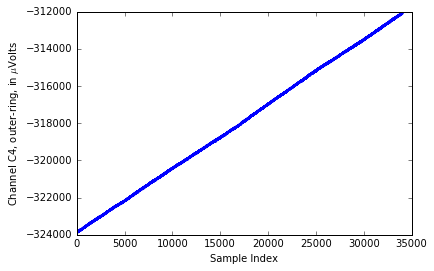

In [8]:
plt.plot(regfile[:-2000,0]);  # Plot all samples except the last 2000
plt.xlabel('Sample Index')
plt.ylabel('Channel C4, outer-ring, in $\mu$Volts');

In [9]:
regfile = regfile[:-2000,:]

Now, let's use our CEBL (from CSU) software to create a CEBL EEG object for each of our two data sets.  Arguments are the matrix of channel data, then a matrix of the marker values, and the channel names. After making an EEG object, we can apply the demean, bandpass and decimate operations to it.  We are filtering between 0.5 Hz and 20 Hz with an order 3 IIR bandpass filter.

In [10]:
tri = cebl.eeg.EEG(trifile[:,:-1], markers=trifile[:,-1], chanNames=['C4','C3','PZ'])
tri = tri.copy().demean().bandpass(0.5, 20, order=3).decimate(3)

reg = cebl.eeg.EEG(regfile[:-2000,:-1], markers=regfile[:-2000,-1], chanNames=['C4','C3','PZ'])
reg = reg.copy().demean().bandpass(0.5, 20, order=3).decimate(3)

print(tri.data.shape,reg.data.shape)

((11987, 3), (10689, 3))


The values in the EEG channels in the two data sets are quite different:

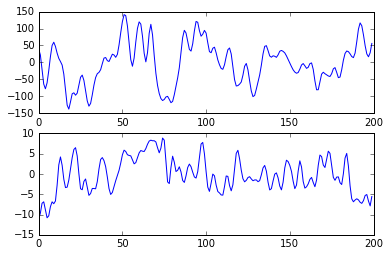

In [11]:
plt.subplot(2,1,1)
plt.plot(tri.data[:200,2])
plt.subplot(2,1,2)
plt.plot(reg.data[:200,2]);

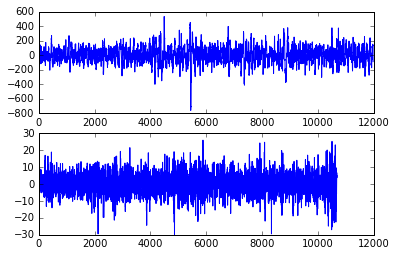

In [12]:
plt.subplot(2,1,1)
plt.plot(tri.data[:,2])
plt.subplot(2,1,2)
plt.plot(reg.data[:,2]);

To make the values fall in similar ranges, just divide by the maximum absolute value in each data set. Don't change the last column, the marker channel.

In [13]:
tri.data[:,:3] /= np.max(np.abs(tri.data[:,:3]))
reg.data[:,:3] /= np.max(np.abs(reg.data[:,:3]))

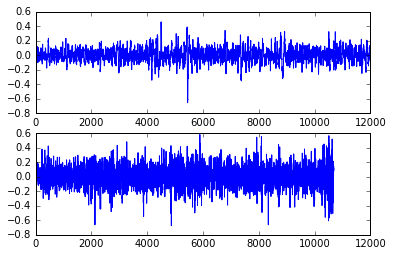

In [14]:
plt.subplot(2,1,1)
plt.plot(tri.data[:,2])
plt.subplot(2,1,2)
plt.plot(reg.data[:,2]);

Now segment the data.  The segment() function uses locations (in time) where the marker channel changes from zero as an indication of the start of a segment.  We form segments starting 0.2 seconds before this and extending for 0.75 seconds beyond this.  The prior 0.2 seconds are used to do baseline correction, which just means the mean EEG in each channel for the prior 0.2 seconds is subtracted from the EEG samples from time 0 to 0.75 seconds.  Thus each segment starts at roughly a zero level.

In [15]:
trisegs = tri.segment(start=-0.2, end=0.75)
regsegs = reg.segment(start=-0.2, end=0.75)

ditching last segment
ditching last segment


In [16]:
trisegs.baselineCorrect()
regsegs.baselineCorrect()

In [17]:
trisegs.data.shape

(360, 82, 3)

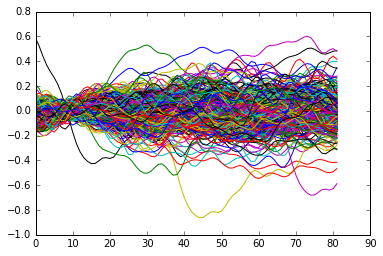

In [18]:
plt.plot(trisegs.data[:,:,2].T);

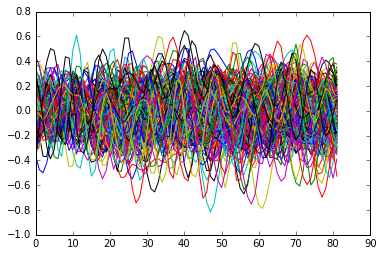

In [19]:
plt.plot(regsegs.data[:,:,2].T);

Now partition the segments into target segments and nontarget segments. The target segments should contain P300's and other signals that correspond to noticing the intended letter flash.

In [20]:
tritargs = trisegs.select(matchFunc=lambda mark: mark > 0.0)
trinontargs = trisegs.select(matchFunc=lambda mark: mark < 0.0)
regtargs = regsegs.select(matchFunc=lambda mark: mark > 0.0)
regnontargs = regsegs.select(matchFunc=lambda mark: mark < 0.0)

In [21]:
tritargs.data.shape

(60, 82, 3)

Let's look at the average of the target and of the nontarget segments.  This is often used to see the P300 waves. Also we plot 6 target and 6 nontarget samples.  There are three electrodes, so we have three plots per kind of electrode.

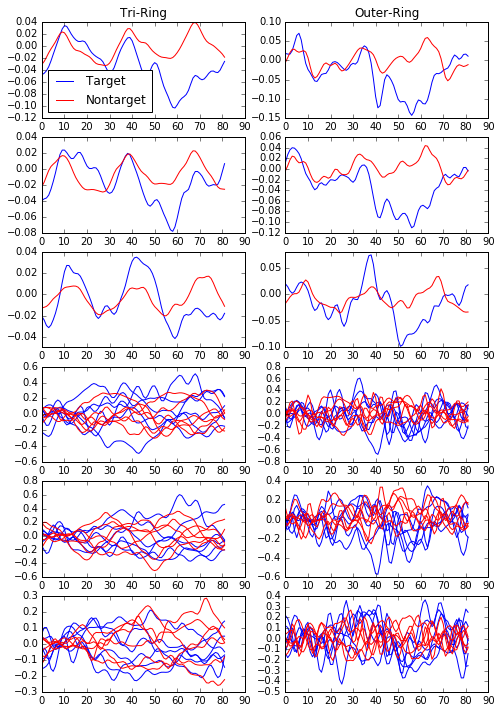

In [22]:
plt.figure(figsize=(8,12))
tritargERP = tritargs.avgERP()
trinontargERP = trinontargs.avgERP()
regtargERP = regtargs.avgERP()
regnontargERP = regnontargs.avgERP()
for c in range(3):
    plt.subplot(6,2,c*2+1)
    plt.plot(tritargERP[:,c])
    plt.plot(trinontargERP[:,c],'r')
    if c == 0:
        plt.title('Tri-Ring')
        plt.legend(('Target','Nontarget'), loc='best')
    
    plt.subplot(6,2,c*2+2)
    if c == 0:
        plt.title('Outer-Ring')
    plt.plot(regtargERP[:,c])
    plt.plot(regnontargERP[:,c],'r')
    
    plt.subplot(6,2,6 + c*2+1)
    plt.plot(tritargs.data[10:16,:,c].T,'b')
    plt.plot(trinontargs.data[10:16,:,c].T,'r')
    
    plt.subplot(6,2,6 + c*2+2)
    plt.plot(regtargs.data[10:16,:,c].T,'b')
    plt.plot(regnontargs.data[10:16,:,c].T,'r');

There are fewer target than nontarget segments.

In [23]:
tritargs.nSeg, trinontargs.nSeg, regtargs.nSeg, regnontargs.nSeg

(60, 300, 52, 263)

In [24]:
tritargs.data.shape, trinontargs.data.shape, regtargs.data.shape, regnontargs.data.shape

((60, 82, 3), (300, 82, 3), (52, 82, 3), (263, 82, 3))

Here is a handy utility function that accepts a function for training a classification model, one for testing it, a list of different parameter values for the classification model, the number of partitions (folds) to divide the data into, whether to randomly shuffle the data first, and an indication that this will be for classification.  If for classification, data is partitioned separately for each class, so the proportion of samples in each class remains the same (or close to the same) in each partition.

In [25]:
def trainValidateTestKFolds(trainf,evaluatef,X,T,parameterSets,nFolds,
                            shuffle=False,classification=False,verbose=False):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    if classification:
        isNewBetterThanOld = lambda new,old: new > old
        folds = {}
        classes = np.unique(T)
        for c in classes:
            classIndices = rowIndices[np.where(T[rowIndices,:] == c)[0]]
            nInClass = len(classIndices)
            nEach = int(nInClass / float(nFolds))
            starts = np.arange(0,nEach*nFolds,nEach)
            stops = starts + nEach
            stops[-1] = nInClass
            # startsStops = np.vstack((rowIndices[starts],rowIndices[stops])).T
            folds[c] = [classIndices, starts, stops]
    else:
        isNewBetterThanOld = lambda new,old: new < old
        # Calculate number of samples in each of the nFolds folds
        nSamples = X.shape[0]
        nEach = int(nSamples / float(nFolds))
        if nEach == 0:
            raise ValueError("trainValidateTestKFolds: Number of samples in each fold is 0.")
        # Calculate the starting and stopping row index for each fold.
        # Store in startsStops as list of (start,stop) pairs
        starts = np.arange(0,nEach*nFolds,nEach)
        stops = starts + nEach
        stops[-1] = nSamples
        startsStops = list(zip(starts,stops))
        
    # Repeat with testFold taking each single fold, one at a time
    results = []
    for testFold in range(nFolds):
        # Leaving the testFold out, for each validate fold, train on remaining
        # folds and evaluate on validate fold. Collect theseRepeat with validate
        # Construct Xtest and Ttest
        if classification:
            rows = rowsInFold(folds,testFold)
        else:
            a,b = startsStops[testFold]
            rows = rowIndices[a:b]
        Xtest = X[rows,:]
        Ttest = T[rows,:]

        bestParms = None
        for parms in parameterSets:
            # trainEvaluationSum = 0
            validateEvaluationSum = 0
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # Construct Xtrain and Ttrain
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                if classification:
                    rows = rowsInFolds(folds,trainFolds)
                else:
                    rows = []
                    for tf in trainFolds:
                        a,b = startsStops[tf]                
                        rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                if classification:
                    rows = rowsInFold(folds,validateFold)
                else:
                    a,b = startsStops[validateFold]
                    rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]

                model = trainf(Xtrain,Ttrain,parms)
                # trainEvaluationSum += evaluatef(model,Xtrain,Train)
                validateEvaluationSum += evaluatef(model,Xvalidate,Tvalidate)
            validateEvaluation = validateEvaluationSum / float(nFolds-1)
            if verbose:
                print(parms,validateEvaluation)
            if bestParms is None or isNewBetterThanOld(validateEvaluation,bestValidationEvaluation): 
                bestParms = parms
                bestValidationEvaluation = validateEvaluation
                if verbose:
                    print('New best')
                # trainEvaluation = trainEvaluationSum / (nFolds-1)

        newXtrain = np.vstack((Xtrain,Xvalidate))
        newTtrain = np.vstack((Ttrain,Tvalidate))
        #nprintRatios(newTtrain,Tvalidate,Ttest)

        model = trainf(newXtrain,newTtrain,bestParms)
        trainEvaluation = evaluatef(model,newXtrain,newTtrain)
        testEvaluation = evaluatef(model,Xtest,Ttest)

        resultThisTestFold = [bestParms, trainEvaluation,
                              bestValidationEvaluation, testEvaluation]
        results.append(resultThisTestFold)
        if verbose:
            print(resultThisTestFold)
    return results

def rowsInFold(folds,k):
    allRows = []
    for c,rows in folds.items():
        classRows, starts, stops = rows
        allRows += classRows[starts[k]:stops[k]].tolist()
    return allRows

def rowsInFolds(folds,ks):
    allRows = []
    for k in ks:
        allRows += rowsInFold(folds,k)
    return allRows

We will try simple classifiers, either Linear Discriminant Analysis (LDA) or Quadratic Discriminant Analysis (QDA) (see [Chuck's notes on LDA and QDA](http://nbviewer.jupyter.org/url/www.cs.colostate.edu/~anderson/cs480/notebooks/14%20Introduction%20to%20Classification.ipynb))

In [26]:
def train(X,T,parms=None):
    if parms == 'q':
        model = ql.QDA()
    else:
        model = ql.LDA()
    model.train(X,T)
    return model

def balancedAccuracy(predict,T):
    matches = np.equal(predict,T)
    classes = np.unique(T)
    sumAcc = 0
    for c in classes:
        sumAcc += np.sum(matches[T==c]) / float(np.sum(T==c))
    return sumAcc / len(classes) * 100

def evaluate(model,X,T):
    predictedClasses, prob, disc = model.use(X)
    return balancedAccuracy(predictedClasses,T)

Need a little function that collects target and nontarget samples into input (X) matrix and correct output matrix (T).

In [52]:
def tvt(targs,nontargs,nFolds):
    if False:  # all channels
        nt = targs.data.shape[0]
        nn = nontargs.data.shape[0]
        X = np.vstack((targs.data.reshape((nt,-1)),
                       nontargs.data.reshape((nn,-1))))
    else:
        channel = 2
        X = np.vstack((targs.data[:,:,channel],nontargs.data[:,:,channel]))
        
    T = np.vstack(([1]*targs.data.shape[0] + [2]*nontargs.data.shape[0]))
    result = trainValidateTestKFolds(train,evaluate,X,T,['q','l'],nFolds,
                shuffle=True,classification=True,verbose=False)
    # result = np.array([r[1:] for r in result])
    result = pandas.DataFrame(result,columns=('Parms','Train','Validate','Test'))
    # print(result)
    # print('Means')
    # print(result.mean(0))
    return result.mean(0), result

In [53]:
meanTrainValTestAcc, allTrainValTestAcc = tvt(tritargs,trinontargs,3)
meanTrainValTestAcc

Train       87.666667
Validate    57.583333
Test        62.000000
dtype: float64

In [54]:
allTrainValTestAcc

Parms  Train  Validate  Test
0     l  89.25     56.50  58.0
1     l  87.50     65.00  55.5
2     l  86.25     51.25  72.5

In [55]:
meanTrainValTestAcc, allTrainValTestAcc = tvt(regtargs,regnontargs,3)
meanTrainValTestAcc

Train       76.500760
Validate    51.276601
Test        53.682517
dtype: float64

In [56]:
allTrainValTestAcc

Parms      Train   Validate       Test
0     l  91.452922  52.308505  57.302231
1     q  50.000000  50.000000  50.000000
2     l  88.049358  51.521298  53.745318

Okay. This seems to be working. Of course accuracy on training partitions is higher.  Test partition accuracy is the important number.  This is how well we would expect a classifier to work on novel data.

So, let's run our cross-validation process for different numbers of folds, from 3 to 10.  Let's repeat this 100 times because each time the data is randomly shuffled so we will get different folds.  Sometimes we get a fold for which a covariance matrix cannot be calculated.  We will catch this exception and just skip that result.

In [57]:
res = []
for reps in range(100):
    print reps,' ',
    for n in range(3,11):
        try:
            r = n, tvt(tritargs,trinontargs,n)[0][-1], tvt(regtargs,regnontargs,n)[0][-1]
            # print(r)
            res.append(r)
        except:
            pass
res = np.array(res)

0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99  


In [58]:
res 

array([[  3.        ,  66.16666667,  56.70498084],
       [  4.        ,  55.66666667,  47.10124434],
       [  5.        ,  60.16666667,  59.43123543],
       ..., 
       [  8.        ,  61.83010299,  58.0458734 ],
       [  9.        ,  59.17508418,  61.13377003],
       [ 10.        ,  62.33333333,  60.94903372]])

In [59]:
means = []
stds = []
num = []
for nf in np.unique(res[:,0]):
    means.append([nf] + res[res[:,0] == nf, 1:].mean(0).tolist())
    stds.append([nf] + res[res[:,0] == nf, 1:].std(0).tolist())
    num.append([nf] + [sum(res[:,0] == nf)])
means = np.array(means)
stds = np.array(stds)
num = np.array(num)

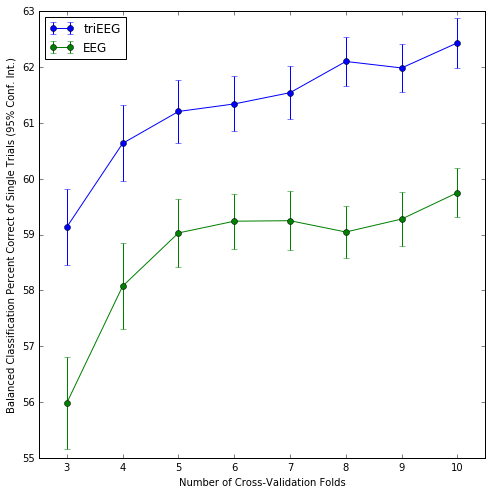

In [73]:
plt.figure(figsize=(8,8))
# plt.plot(means[:,0],means[:,1:],'o-');
# n = means.shape[0]
sqrnums = np.sqrt(num[:,1])
plt.errorbar(means[:,0], means[:,1], yerr=1.96 * stds[:,1] / sqrnums,fmt='-o')
plt.errorbar(means[:,0], means[:,2], yerr=1.96 * stds[:,2] / sqrnums ,fmt='-o')
plt.xlim(2.5,10.5)
plt.xlabel('Number of Cross-Validation Folds')
plt.ylabel('Balanced Classification Percent Correct of Single Trials (95% Conf. Int.)')
plt.legend(('triEEG','EEG'),loc='best');